In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

<h1> Introduction </h1>

The objective of this analysis is to determine if there is a wage gap between men and women in canada. The dataset used is from Statistics Canada, which is the federal statistical agency of Canada.

Dataset: The dataset used in the analysis if from the 
2011 National Household Survey (Catalogue Number:99-014-X2011042).

<h1> Cleaning the Data </h1>

In [2]:
def set_index(df):
    group = ''
    subgroup = ''
    area = ''
    position = ''
    to_drop = []
    for index,row in df.iterrows():
        key = row['Occupation'].split()
        if len(key[0].split('-')[0]) == 1:
            group = ' '.join(key[1:])
            to_drop.append(index)
        elif len(key[0].split('-')[0]) == 2:
            subgroup = ' '.join(key[1:])
            to_drop.append(index)
        elif len(key[0].split('-')[0]) == 3:
            area = ' '.join(key[1:])
            to_drop.append(index)
        elif len(key[0].split('-')[0]) == 4:
            position = ' '.join(key[1:])
            df.loc[index,'Area'] = group
            df.loc[index,'SubGroup'] = subgroup
            df.loc[index,'Industry'] = area
            df.loc[index,'Position'] = position
    df = df.drop(df.index[to_drop]).drop('Occupation', axis=1)
    df = df.reset_index().drop(['index'], axis=1)
    #df = df.set_index(['Area','SubGroup','Industry','Position'])
    return df

def clean(dataset):
    df = pd.read_csv(filepath_or_buffer=dataset, skiprows=6, encoding = "ISO-8859-1")
    df = df.drop(df.index[[0, 1, 2, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704]])
    df.columns = ['Occupation', 'Total', 'WithIncome', 'MedEmpIncome', 'AvgEmpIncome', 'WithWage',
                  'MedWage', 'AvgWage', 'drop']
    
    df = df.drop('drop', axis=1)
    df['Area'] = ''
    df['SubGroup'] = ''
    df['Industry'] = ''
    df['Position'] = ''
    df = df.reset_index().drop(['index'], axis=1)
    return set_index(df)
    

df_male = clean('male_income.csv')
df_female = clean('female_income.csv')

df_male['Gender'] = 'Male'
df_female['Gender'] = 'Female'

frames = [df_male, df_female]

df = pd.concat(frames).reset_index().drop(['index'], axis=1)

<h1> Exploring the data </h1>

In [4]:
print(df.groupby('Gender').mean()['AvgEmpIncome'])

Gender
Female    41592.242
Male      54143.030
Name: AvgEmpIncome, dtype: float64


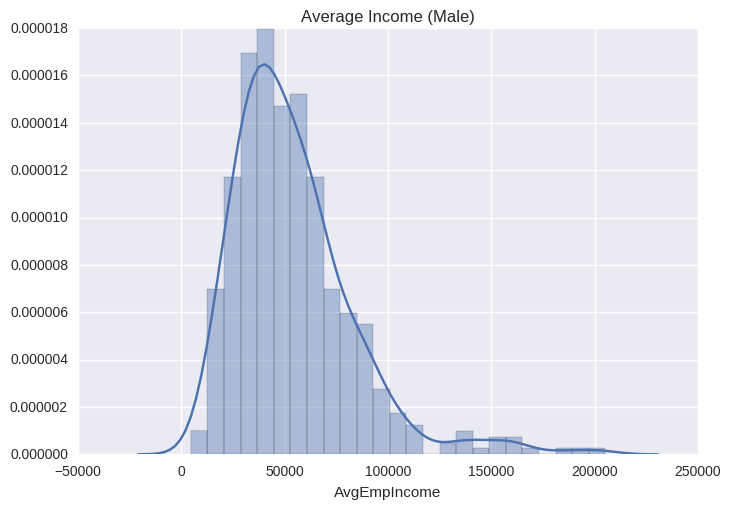

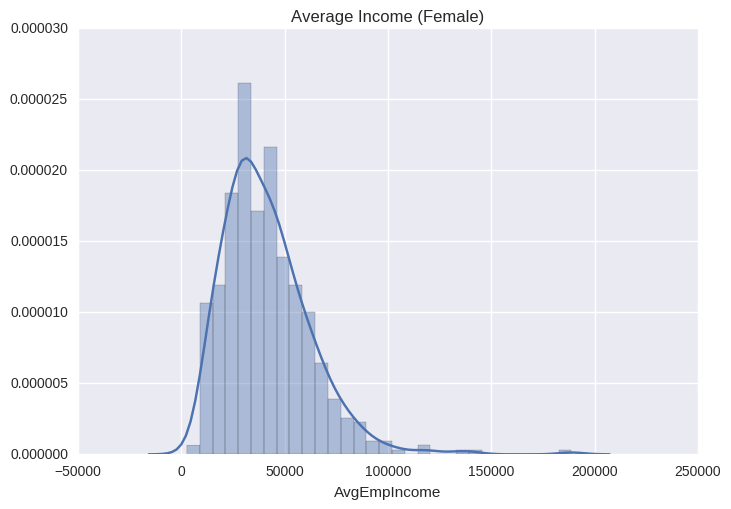

In [5]:
plt.figure()
plt.title('Average Income (Male)')
sns.distplot(df[df['Gender']=='Male']['AvgEmpIncome'])
plt.savefig('male_distribution.png')

plt.figure()
plt.title('Average Income (Female)')
sns.distplot(df[df['Gender']=='Female']['AvgEmpIncome'])
plt.savefig('female_distribution.png')

plt.show()

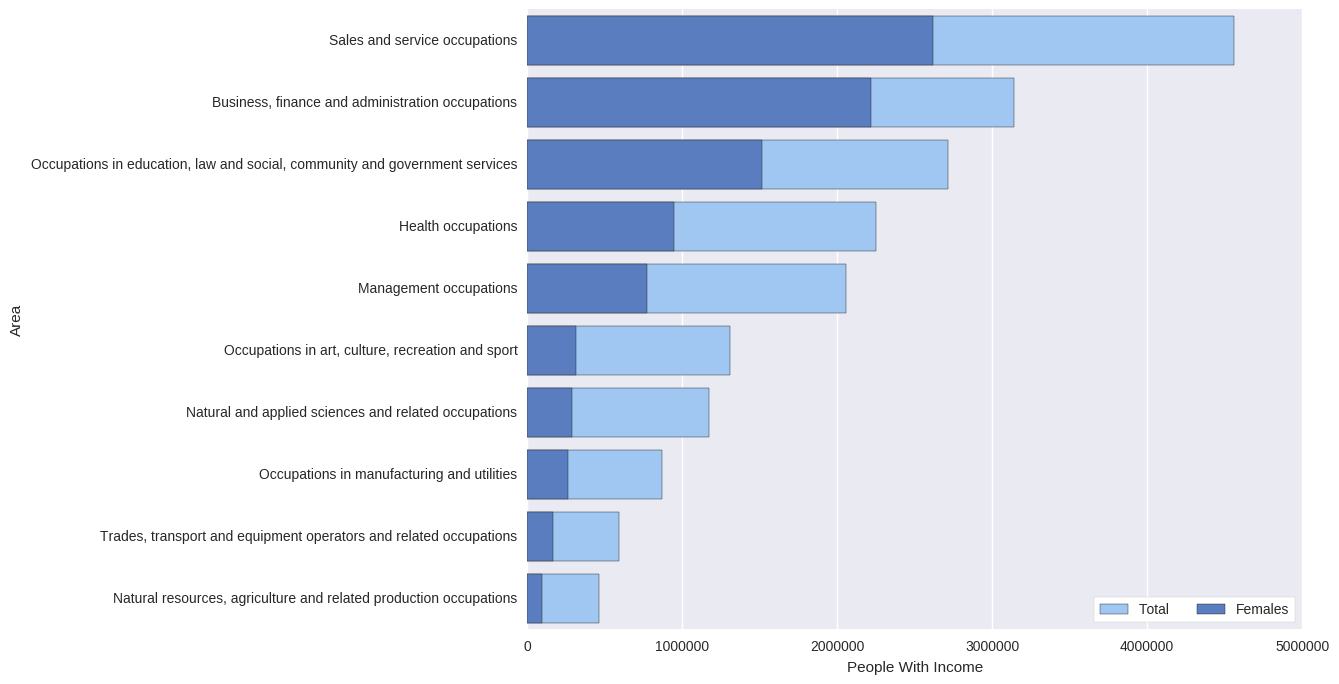

In [6]:
f, ax = plt.subplots(figsize=(10, 8))
sns.set(style="whitegrid")

sns.set_color_codes("pastel")
sns.barplot(x='Total', y='Area', data=df.groupby('Area').sum().sort_values('Total', ascending=False).reset_index(), 
            color='b', label='Total', ci=None)   

sns.set_color_codes("muted")
sns.barplot(x='Total', y='Area', 
            data=df[df['Gender']=='Female'].groupby('Area').sum().sort_values('Total', ascending=False).reset_index(), 
            color='b', label='Females', ci=None)   

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="People With Income")
sns.despine(left=True, bottom=True)

plt.savefig('females_per_area.png', bbox_inches='tight')
plt.show()

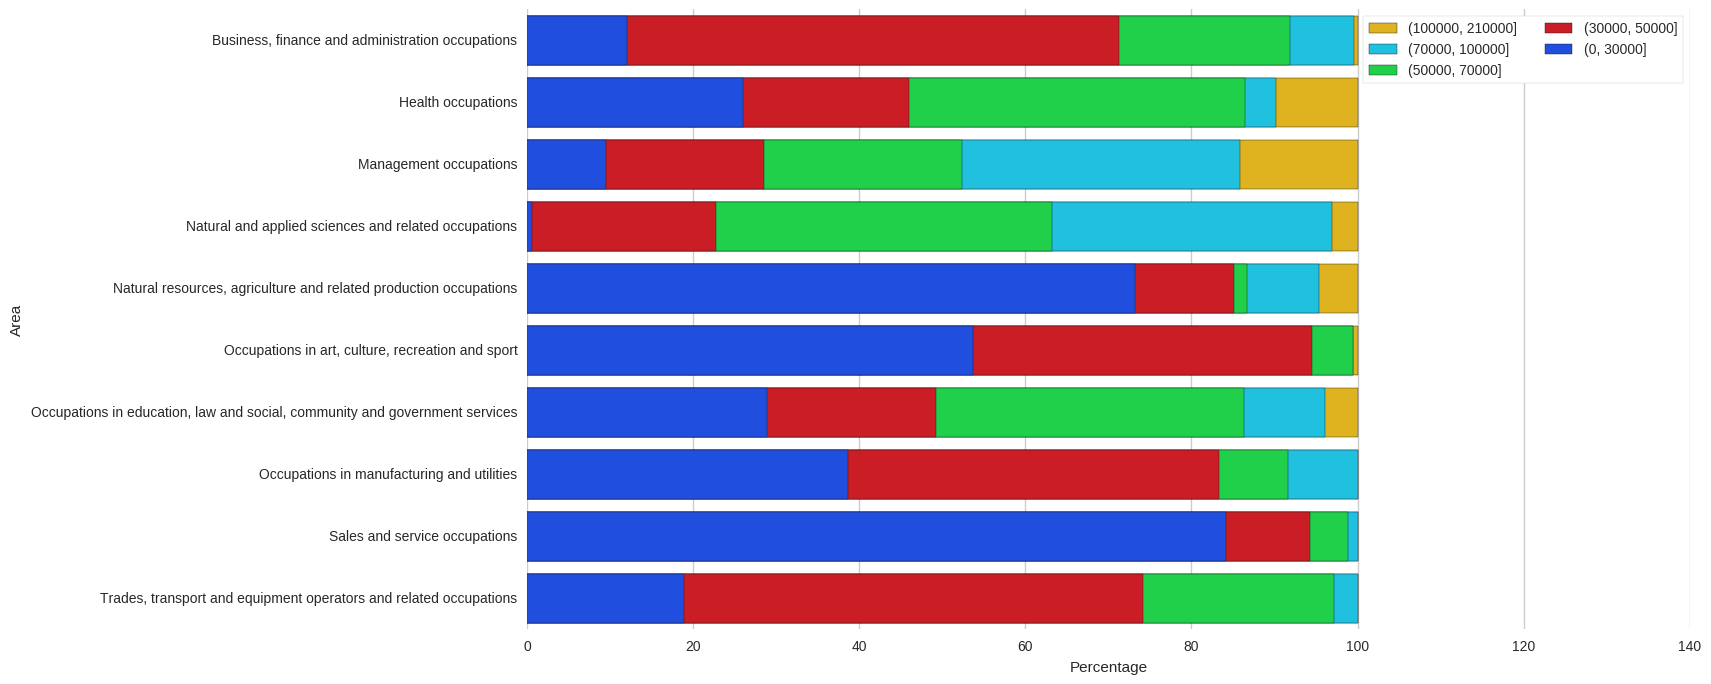

In [21]:
bins = [0, 30000, 50000, 70000, 100000, 210000]
df['Categories'] = pd.cut(df['AvgEmpIncome'], bins)

income_per_industry = df.groupby(['Area', 'Categories']).sum().dropna().reset_index()

normalizer = {income_per_industry['Area'].unique()[i] : 
              income_per_industry[income_per_industry['Area'] == income_per_industry['Area'].unique()[i]]['Total'].sum()
              for i in range(len(income_per_industry['Area'].unique()))}

income_per_industry['Fraction'] = 0

for i, row in income_per_industry.iterrows():
    income_per_industry.loc[i, 'Fraction'] = 100 * row['Total'] / normalizer[row['Area']]
    
colors = ['b', 'r', 'g', 'c', 'y']

f, ax = plt.subplots(figsize=(15, 8))
sns.set(style="whitegrid")

for i in range(4,-1,-1):
    sns.set_color_codes("bright")
    sns.barplot(y='Area', x='Fraction', label=income_per_industry['Categories'].unique()[i], estimator=sum, 
                data=income_per_industry[income_per_industry['Categories'].isin(income_per_industry['Categories'].unique()[:i+1])], 
                color=colors[i], ci=None)   

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set_xlim(0,140)
ax.set(xlabel="Percentage")
sns.despine(left=True, bottom=True)

plt.savefig('income_per_area.png', bbox_inches='tight')
plt.show()


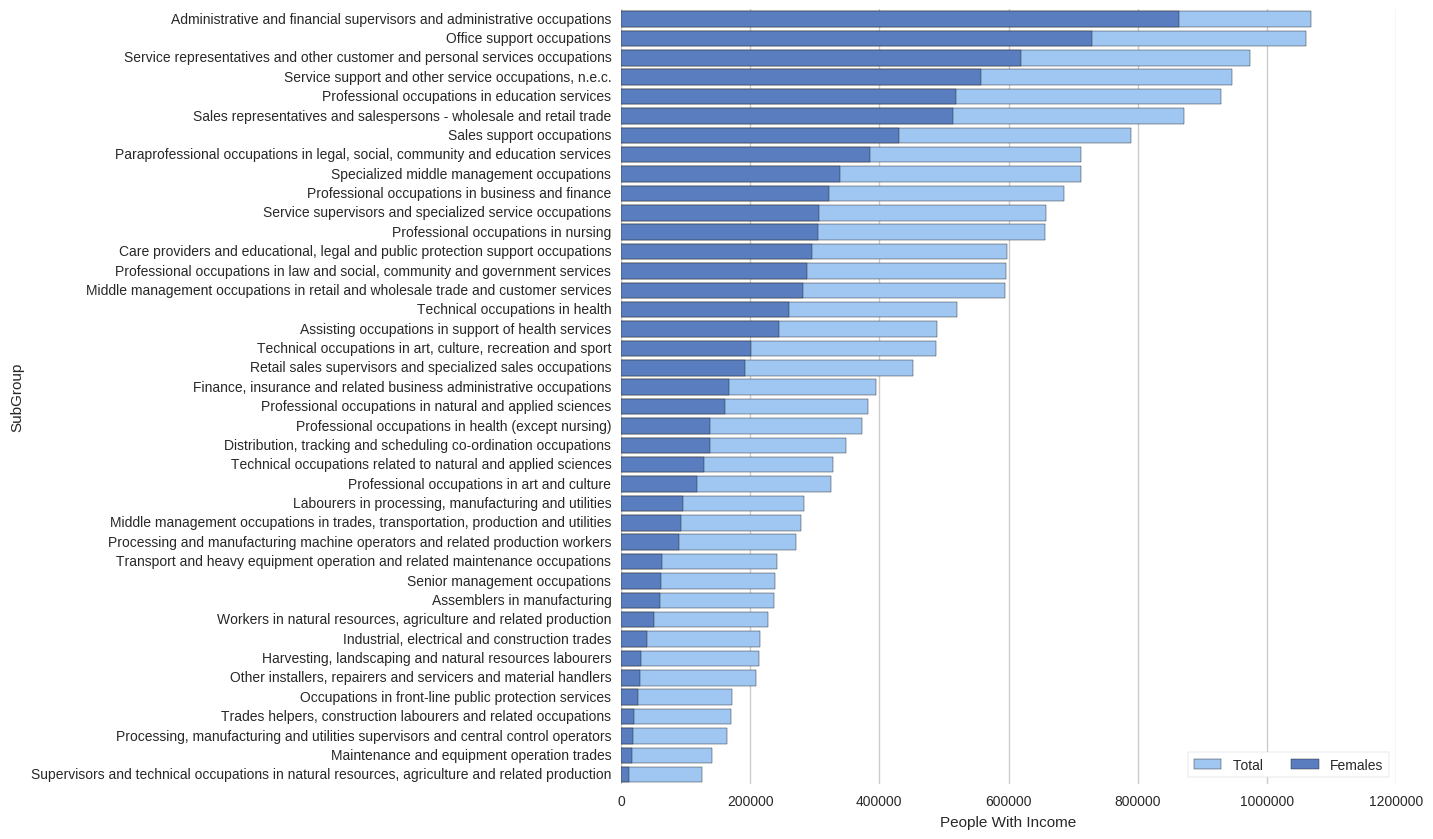

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid")

sns.set_color_codes("pastel")
sns.barplot(x='Total', y='SubGroup', data=df.groupby('SubGroup').sum().sort_values('Total', ascending=False).reset_index(), 
            color='b', label='Total', ci=None)   

sns.set_color_codes("muted")
sns.barplot(x='Total', y='SubGroup', 
            data=df[df['Gender']=='Female'].groupby('SubGroup').sum().sort_values('Total', ascending=False).reset_index(), 
            color='b', label='Females', ci=None)   

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="People With Income")
sns.despine(left=True, bottom=True)

plt.savefig('females_per_sg.png', bbox_inches='tight')
plt.show()

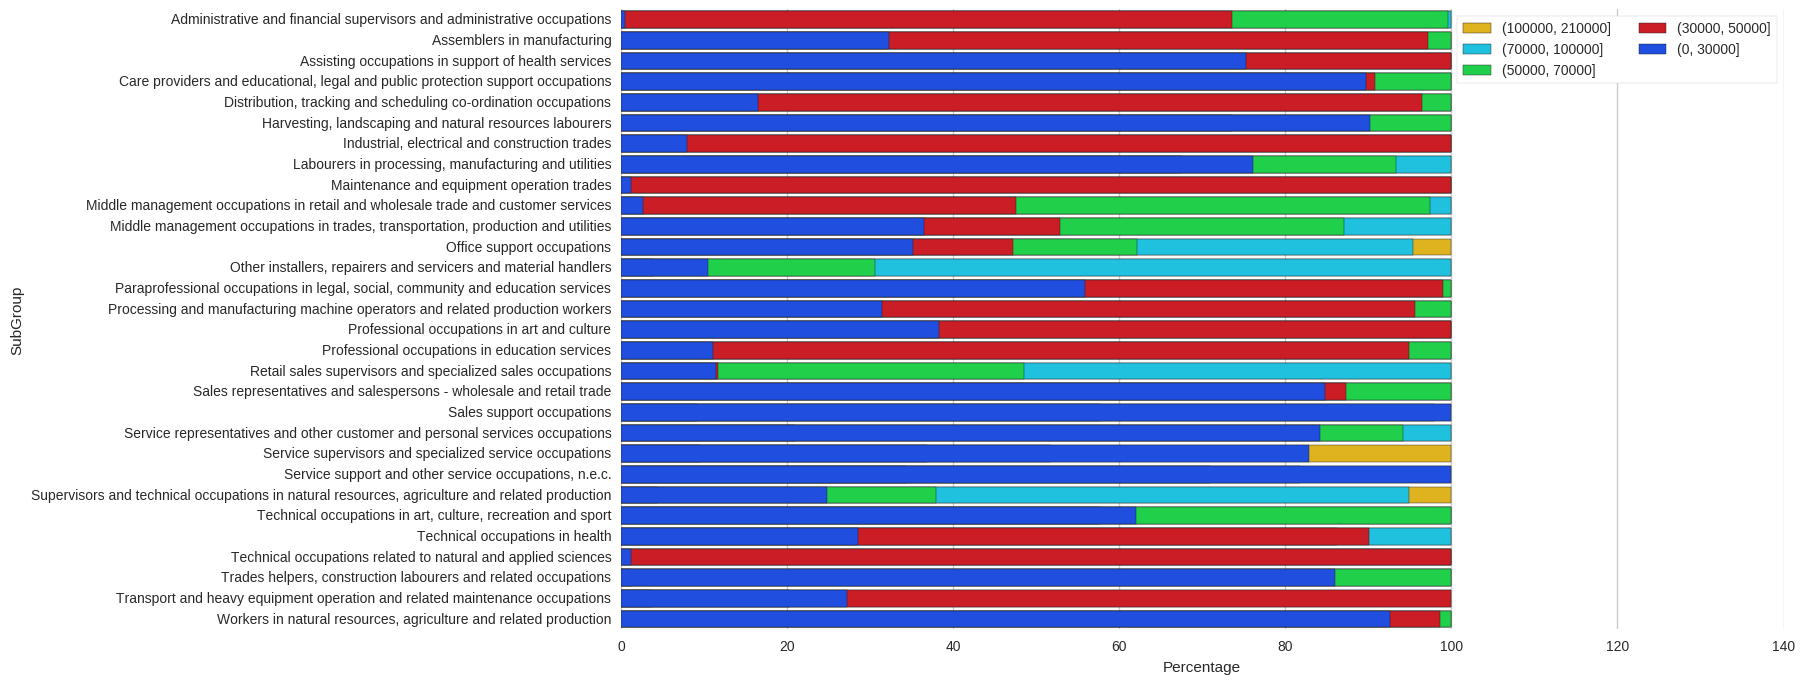

In [22]:
income_per_sg = df.groupby(['SubGroup', 'Categories']).sum().dropna().reset_index()

normalizer = {income_per_sg['SubGroup'].unique()[i] : 
              income_per_sg[income_per_sg['SubGroup'] == income_per_sg['SubGroup'].unique()[i]]['Total'].sum()
              for i in range(len(income_per_sg['SubGroup'].unique()))}

income_per_sg['Fraction'] = 0

for i, row in income_per_sg.iterrows():
    income_per_sg.loc[i, 'Fraction'] = 100 * row['Total'] / normalizer[row['SubGroup']]
    
colors = ['b', 'r', 'g', 'c', 'y']

f, ax = plt.subplots(figsize=(15, 8))
sns.set(style="whitegrid")

for i in range(4,-1,-1):
    sns.set_color_codes("bright")
    sns.barplot(y='SubGroup', x='Fraction', label=income_per_sg['Categories'].unique()[i], estimator=sum, 
                data=income_per_sg[income_per_sg['Categories'].isin(income_per_sg['Categories'].unique()[:i+1])], 
                color=colors[i], ci=None)   

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set_xlim(0,140)
ax.set(xlabel="Percentage")
sns.despine(left=True, bottom=True)

plt.savefig('income_per_sg.png', bbox_inches='tight')
plt.show()

In [36]:
df['TypeOfIncome'] = df.apply(lambda row: 'High' if row['AvgEmpIncome'] > 50000 else 'Low', axis=1)


print('Percentage of women out of the people with high paying jobs: {0}'.format(
        100 * df[(df['Gender'] == 'Female') & (df['TypeOfIncome'] == 'High')]['Total'].sum() / 
        df[(df['TypeOfIncome'] == 'High')]['Total'].sum()))

print('Percentage of women with high paying jobs: {0}'.format(
        100 * df[(df['Gender'] == 'Female') & (df['TypeOfIncome'] == 'High')]['Total'].sum() / 
        df[(df['Gender'] == 'Female')]['Total'].sum()))

Percentage of women out of the people with high paying jobs: 33.380373383341855
Percentage of women with high paying jobs: 23.069253893676063


<h1> Ratio Analysis </h1>

In [54]:
df2 = df_male.merge(df_female, how='inner', on=['Area', 'SubGroup', 'Industry', 'Position'], suffixes=('_M','_F'))
df2['Ratio'] = df2['AvgEmpIncome_F'] / df2['AvgEmpIncome_M']
ratio = df2[['Area', 'SubGroup', 'Industry', 'Position', 'Ratio', 'Total_M', 'Total_F']]

print('Positions where women earn more than men on average: \n {0}'.format(ratio[ratio['Ratio'] >= 1]['Position']))

Positions where women earn more than men on average: 
 69                       Legal administrative assistants
71     Court reporters, medical transcriptionists and...
81                                         Receptionists
84                                     Data entry clerks
90                         Library assistants and clerks
163              Information systems testing technicians
197                                    Dental assistants
223                    Paralegal and related occupations
248                                              Dancers
251               Library and public archive technicians
284                                                Cooks
313                                             Cashiers
315       Store shelf stockers, clerks and order fillers
317    Food counter attendants, kitchen helpers and r...
339                            Power system electricians
353                                Roofers and shinglers
359    Contractors and supervisor

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


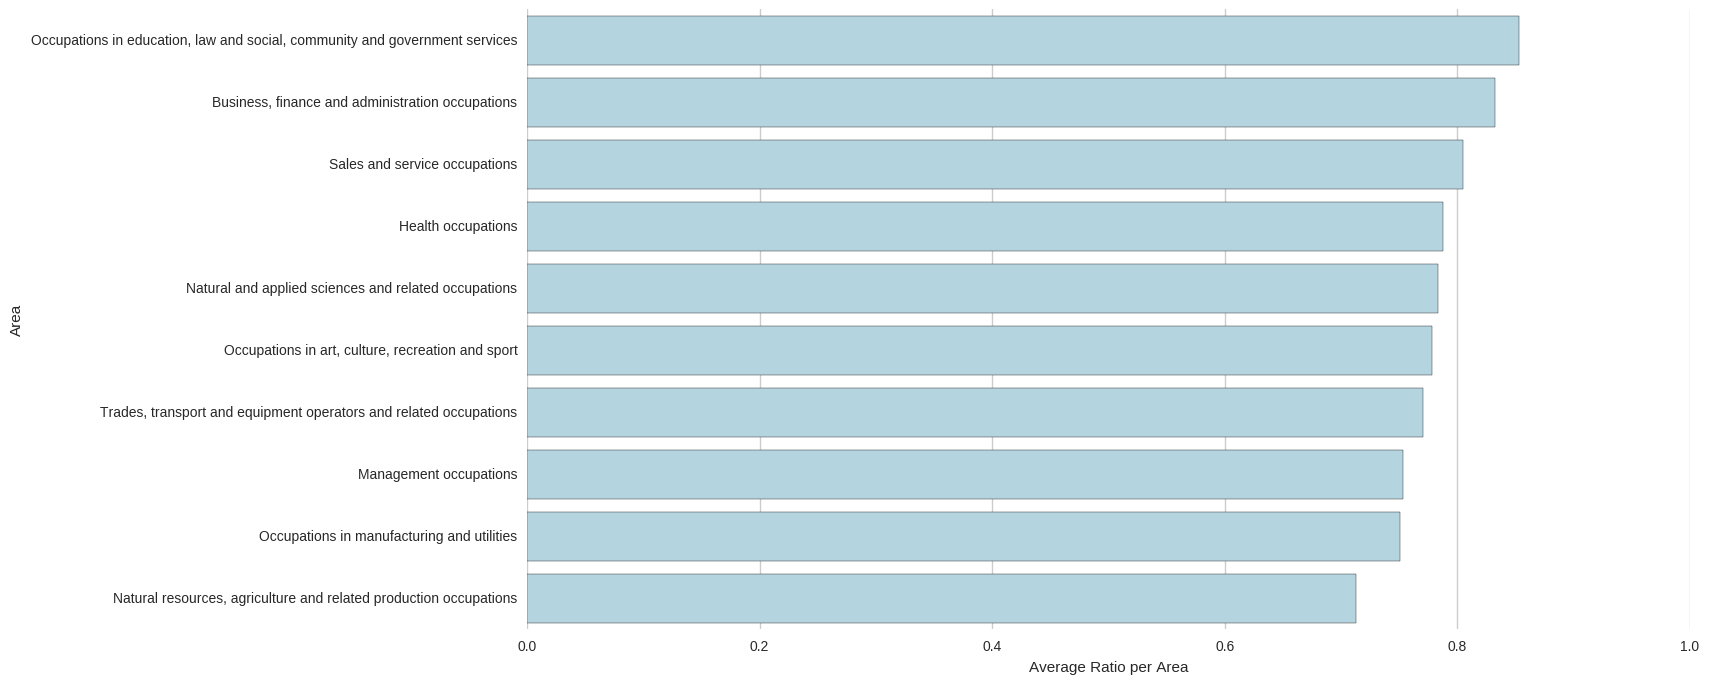

In [71]:
f, ax = plt.subplots(figsize=(15, 8))
sns.set(style="whitegrid")

sns.set_color_codes("bright")
sns.barplot(x='Ratio', y='Area', 
            data=ratio.groupby('Area').mean().sort_values('Ratio', ascending=False).reset_index(), 
            ci=None, color='lightblue')   

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="Average Ratio per Area")
sns.despine(left=True, bottom=True)
ax.set_xlim([0,1])

plt.savefig('ratio_per_area.png', bbox_inches='tight')
plt.show()


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


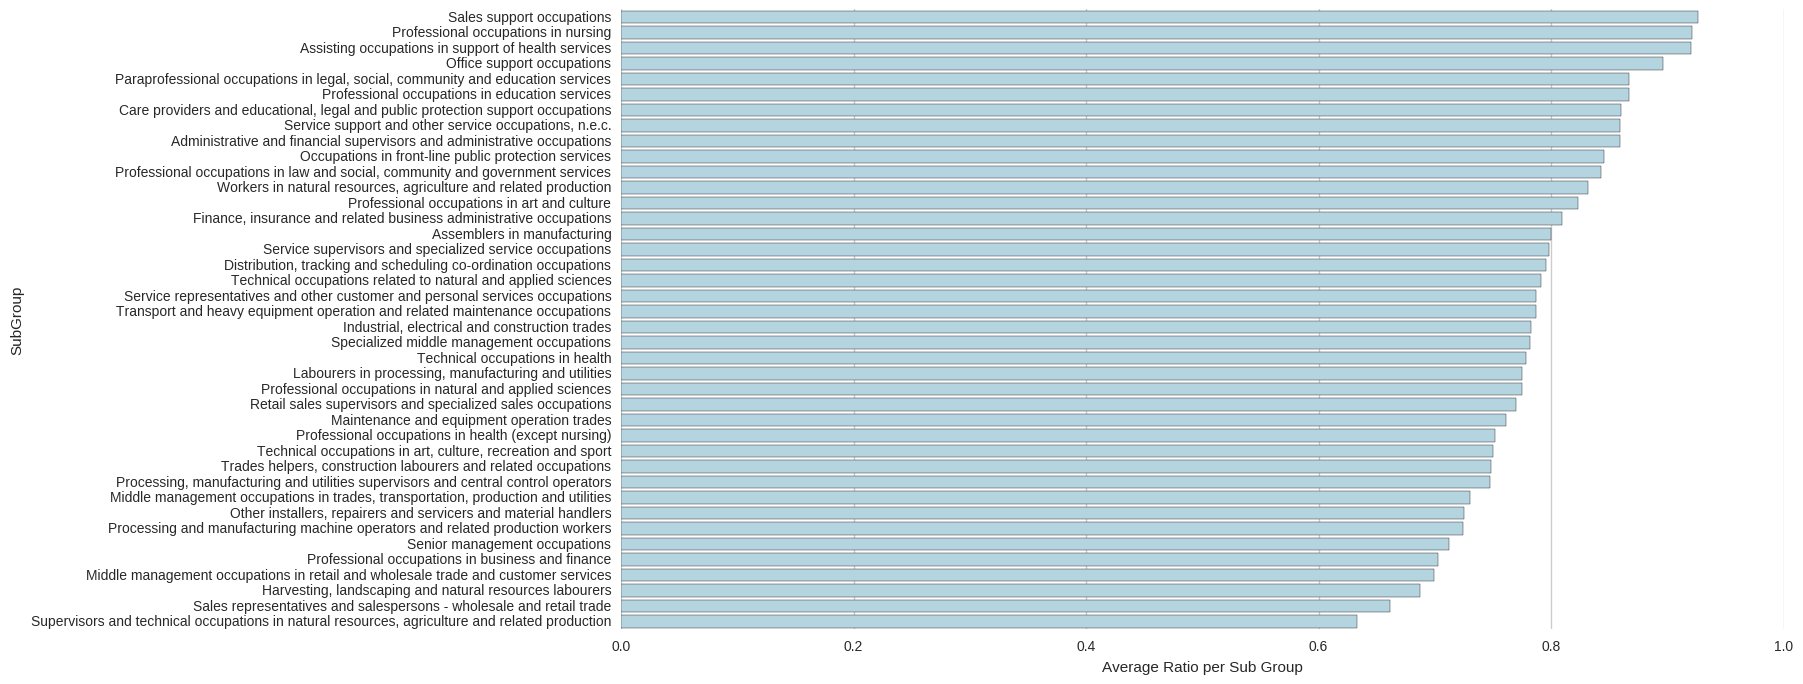

In [74]:
f, ax = plt.subplots(figsize=(15, 8))
sns.set(style="whitegrid")

sns.set_color_codes("bright")
sns.barplot(x='Ratio', y='SubGroup', 
            data=ratio.groupby('SubGroup').mean().sort_values('Ratio', ascending=False).reset_index(), 
            ci=None, color='lightblue')   

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlabel="Average Ratio per Sub Group")
sns.despine(left=True, bottom=True)
ax.set_xlim([0,1])

plt.savefig('ratio_per_sg.png', bbox_inches='tight')
plt.show()

In [80]:
print('Positions with least ratio:')
(ratio
 .sort_values('Ratio', ascending=True)
 .reset_index()
 .drop(['index', 'Area', 'SubGroup', 'Industry'], axis=1).head(10))

Positions with least ratio:


,Position,Ratio,Total_M,Total_F
0,Athletes,0.158363,3365.0,565.0
1,Fishing masters and officers,0.413097,2790.0,115.0
2,"Securities agents, investment dealers and brokers",0.460758,12420.0,5980.0
3,"Agricultural service contractors, farm supervi...",0.461337,7185.0,3535.0
4,Managers in horticulture,0.488123,3150.0,1975.0
5,"Banking, credit and other investment managers",0.490286,33820.0,44655.0
6,Logging machinery operators,0.495047,10830.0,240.0
7,Geoscientists and oceanographers,0.520811,11185.0,3220.0
8,"Motorcycle, all-terrain vehicle and other rela...",0.527924,5305.0,25.0
9,Papermaking and finishing machine operators,0.536995,2950.0,480.0


<h1> Hypothesis Testing </h1>

In [88]:
from scipy.stats import ttest_ind, ttest_1samp

tstat, pval = ttest_1samp(ratio['Ratio'], 1)
print(pval/2)

8.88187006852e-160


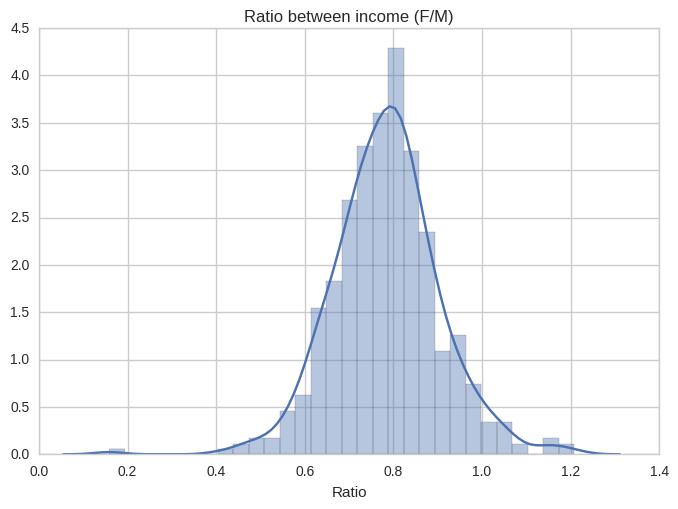

In [89]:
plt.figure()
plt.title('Ratio between income (F/M)')
sns.distplot(ratio['Ratio'])

plt.savefig('ratio_dist.png')
plt.show()